In [1]:
import eko
import pineappl 
import numpy as np
import yaml

import pdffit

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
from torch.optim.swa_utils import AveragedModel

from matplotlib import pyplot as plt
from IPython.display import clear_output
from pdffit.examples.evolution.evo_bases import *

plt.rcParams.update({
    #"figure.dpi": 100,               
    #"savefig.dpi": 100,             
    "figure.figsize": (10, 6),
    'text.usetex': True,
    "font.family": 'Computer Modern',  
    "font.size": 15     
})

device = pdffit.device

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys import convolution
from validphys.core import PDF

LHAPDF was not found, using an alternative backend


In [2]:
# Define the input parameters
# inp = {
#     "dataset_input": {"dataset": "HERA_NC_318GEV_EM-SIGMARED", "variant": "legacy"},  # See https://inspirehep.net/literature/276661
#     "use_cuts": "internal",
#     "theoryid": 40000000,
# }

inp = {
	"dataset_input": {"dataset": "BCDMS_NC_NOTFIXED_P_EM-F2", "variant": "legacy_dw"},  # See https://inspirehep.net/literature/276661
	"use_cuts": "internal",
	"theoryid": 40000000,
}

# Load the data using the validphys API
dataset = API.dataset(**inp)

# Covariance matrix for the SLAC data
covariance_matrix = API.covmat_from_systematics(**inp)

# NOTE: There is only one FK table for this dataset
FKTableData = load_fktable(*dataset.fkspecs).with_cuts(dataset.cuts)

xgrid = np.array(FKTableData.xgrid, dtype=np.float64)
xgrid_torch = torch.tensor(xgrid, device=device, dtype=torch.float64).detach()[:-1]
print(xgrid_torch.shape)

# NOTE: flavors are in the evolution basis
ACTIVE_FLAVORS = FKTableData.luminosity_mapping
print(ACTIVE_FLAVORS)

fk_array = FKTableData.get_np_fktable()
fk_array_torch = torch.tensor(fk_array, device=device, dtype=torch.float64).requires_grad_(False)
fk_array_torch = fk_array_torch[:, :, :-1]  # remove the last x, Q2, and flavor

fk_array_torch.shape

torch.Size([25])
[ 1  2  3  4  5  6  9 10 11]


torch.Size([333, 9, 25])

In [3]:
# NOTE: can be improved by performing the rotation to flavor basis at the end of the fit
# 
channels = pineappl.fk_table.FkTable.read(dataset.fkspecs[0].fkpath[0])._raw.channels()
channels

[(21, 11),
 (103, 11),
 (108, 11),
 (115, 11),
 (100, 11),
 (203, 11),
 (208, 11),
 (215, 11),
 (200, 11)]

In [4]:
def sort_rm(channels):
	"""
	TODO: docstring
	"""
	ev_pid = np.array(eko.basis_rotation.evol_basis_pids)
	idx = np.zeros(14, dtype=np.int32)
	for i, item in enumerate(channels):
		idx[i] = np.sum(np.where(ev_pid == item[0], np.arange(0, 14), 0))
	return idx #eko.basis_rotation.rotate_flavor_to_evolution[idx]


def sort_rm_new():
	"""
	TODO: docstring
	"""
	return eko.basis_rotation.rotate_flavor_to_evolution


def beta_pdf(x, b):
    """
    TODO: docstring
    """
    return torch.exp(b.log_prob(x))

def to_sigmared(fk, rotpdf):
	"""
	Forward map. Maps PDF to data space.
	
	Parameters
	----------
	fk: 
	
	rotpdf:
	
	Returns
	-------
	"""
	return (fk[:,:,:] * rotpdf).sum((1,2))

class mean_adjust:
	"""
	TODO: docstring
	"""
	def __init__(self, p_0, n = 1000):
		self.xrange = torch.linspace(1e-5, 1-1e-5, n, device=device)
		self.base = p_0
	def mean_flown_(self, f):
		return torch.mean(self.xrange*pdffit.nn.flown(self.xrange.view(-1,1), f, self.base).exp())

In [5]:
ACTIVE_FLAVORS = torch.tensor(sort_rm(channels), device=device, dtype=torch.int64)[:9]

rm_eko_flavor_evo = torch.tensor(eko.basis_rotation.rotate_flavor_to_evolution, device=device, dtype=torch.float64)

#### Generation of pseudodata

In order to validate the fitting methodology we can make use of a closure test.
References: ...

##### Level 0 Closure test


Starting from some known underlying law $f_{in}$ we generate some (level 0) fakedata using our forward map 
$$
L_{0, i} = \sum_{jk} FK_{ijk}f_{\rm {in}, jk}
$$
, where $i$ indexes data-point, $j$ active flavors, and $k$ the xgrid points used in the convolution.

$f_{in}$ should be some realisation of the parametrisation that we are using, eg, if the parametrisation is $f(x) = A x^a (1-x)^b$ then $f_{in}$ could be something like $f_{in}(x; a_0, b_0) = A x^{a_0} (1-x)^{b_0} $.


In the fit we optimise something like

$$
L(f) = (L_0 - FK_{ijk}f_{jk})^TC^{-1}(L_0 - FK_{ijk}f_{jk})
$$

wrt the parameters upon which $f$ depends on. Given that theory (forward map) and data are perfectly compatible in this case, we would expect to be able to perfectly minimise the Loss function.



##### Level 1 closure test

In a level 1 closure test we can simulate real data in a more realistic way, assuming that the measured data has distribution
$$
D \sim \mathcal{N}(D_0, \Sigma)
$$
where $D_0$ is the measure instance of the data and $\Sigma$ is the covariance matrix, we can generate $L_1$ data as

$$
L_1 = L_0 + \eta, \quad \eta \sim \mathcal{N}(0, C)
$$



Definition of underlying law

##### Evolution Basis

\begin{alignat*}{3}
\text{Valence Basis:}& \quad \text{span}&&(\gamma,\quad \bar{t},\quad \bar{b},\quad \bar{c},\quad \bar{s},\quad \bar{u},\quad \bar{d},\quad g,\quad d_v,\quad u_v,\quad s,\quad c,\quad b,\quad t)\\[2em]
\text{+/- Basis:}& \quad q^\pm &&= q \pm \bar{q}\\[2em]
\text{Singlet:}& \quad \Sigma &&= \sum_{j}^6 q_j^+\\
\text{Valence like:} 
&&&\left\{
\begin{alignat*}{2}
V &= \sum_{j}^6 q_j^-\\
V_3 &= u^- - d^-\\
V_8 &= u^- + d^- - 2s^-\\
V_{15} &= u^- + d^- + s^- - 3c^-\\
V_{24} &= u^- + d^- + s^- + c^- - 4b^-\\
V_{35} &= u^- + d^- + s^- + c^- + b^- - 5t^-
\end{alignat*}
\right.\\
\text{Singlet like:} 
&&&\left\{
\begin{alignat*}{2}
T_3 &= u^+ - d^+\\
T_8 &= u^+ + d^+ - 2s^+\\
T_{15} &= u^+ + d^+ + s^+ - 3c^+\\
T_{24} &= u^+ + d^+ + s^+ + c^+ - 4b^+\\
T_{35} &= u^+ + d^+ + s^+ + c^+ + b^+ - 5t^+
\end{alignat*}
\right.\\[5em]
&&&\begin{aligned}
\mathcal{F} \sim \mathcal{F}_{ev} = \text{span}(
&\gamma, &&\Sigma, &&g, &&V, &&V_3, &&V_8, &&V_{15}, &&V_{24}, &&V_{35}, &&T_3, &&T_8, &&T_{15}, &&T_{24}, &&T_{35})\\
&0, &&1, &&2, &&3, &&4, &&5, &&6, &&7, &&8, &&9, &&10, &&11, &&12, &&13
\end{aligned}
\end{alignat*}

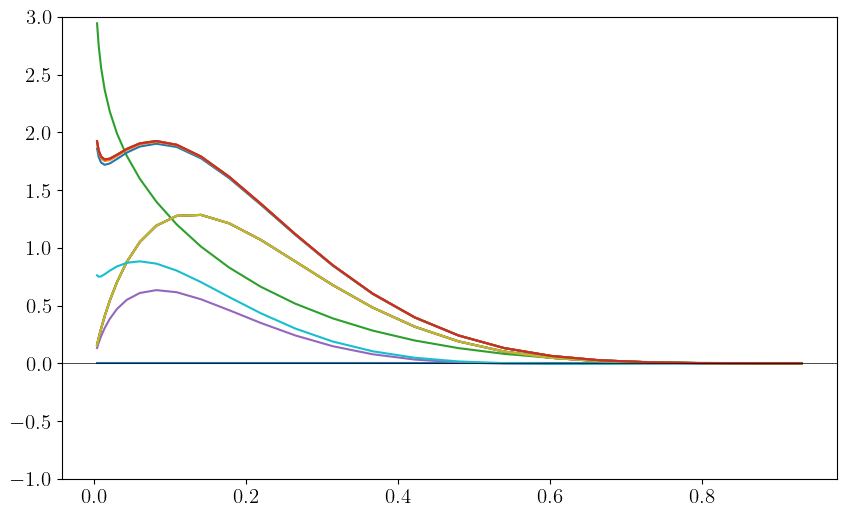

In [31]:
beta_uv_in = torch.distributions.Beta(torch.tensor(1.8, device=device), torch.tensor(7.4, device=device))
beta_dv_in = torch.distributions.Beta(torch.tensor(2.2, device=device), torch.tensor(6.7, device=device))

beta_ub_in = torch.distributions.Beta(torch.tensor(0.81, device=device), torch.tensor(5.3, device=device))
beta_db_in = torch.distributions.Beta(torch.tensor(0.83, device=device), torch.tensor(4.8, device=device))
beta_g_in  = torch.distributions.Beta(torch.tensor(0.85, device=device), torch.tensor(4.7, device=device))
beta_s_in  = torch.distributions.Beta(torch.tensor(0.78, device=device), torch.tensor(5.2, device=device))
beta_c_in  = torch.distributions.Beta(torch.tensor(0.77, device=device), torch.tensor(4.9, device=device))

#defined in a way that delta_uv + delta_dv + 2*delta_ub + 2*delta_db + delta_g + 2*delta_s + 2*delta_c = 1

deltas_flavor = torch.zeros((14,), device=device, dtype=torch.float64)

delta_uv = 0.27
delta_dv = 0.1275
delta_db = 0.07  /2; deltas_flavor[6] = delta_db
delta_ub = 0.13  /2; deltas_flavor[5] = delta_ub
delta_g  = 0.4     ; deltas_flavor[7] = delta_g
delta_s  = 0.002 /2; deltas_flavor[4] = delta_s; deltas_flavor[10] = delta_s
delta_c  = 0.0005/2; deltas_flavor[3] = delta_c; deltas_flavor[11] = delta_c

delta_u = delta_uv + delta_ub; deltas_flavor[9] = delta_u
delta_d = delta_dv + delta_db; deltas_flavor[8] = delta_d

deltas_evo = torch.matmul(rm_eko_flavor_evo, deltas_flavor).requires_grad_(False)

pdf_input = torch.zeros((14, xgrid_torch.shape[0]), device=device, dtype=torch.float64)

pdf_input[9] = delta_uv * beta_uv_in.log_prob(xgrid_torch).exp() + delta_ub * beta_ub_in.log_prob(xgrid_torch).exp()
pdf_input[8] = delta_dv * beta_dv_in.log_prob(xgrid_torch).exp() + delta_db * beta_db_in.log_prob(xgrid_torch).exp()

pdf_input[5] = delta_ub * beta_ub_in.log_prob(xgrid_torch).exp()
pdf_input[7] = delta_g  * beta_g_in.log_prob(xgrid_torch).exp()
pdf_input[6] = delta_db * beta_db_in.log_prob(xgrid_torch).exp()

pdf_input[10] = delta_s * beta_s_in.log_prob(xgrid_torch).exp()
pdf_input[4]  = delta_s * beta_s_in.log_prob(xgrid_torch).exp()
pdf_input[11] = delta_c * beta_c_in.log_prob(xgrid_torch).exp()
pdf_input[3]  = delta_c * beta_c_in.log_prob(xgrid_torch).exp()

# rotate the input pdf to the evolution basis
pdf_input_ev = torch.matmul(rm_eko_flavor_evo, pdf_input)

fig, ax = plt.subplots()
ax.set_ylim(-1,3)
for i in range(14):
    ax.plot(xgrid_torch.cpu().numpy(), pdf_input_ev[i].cpu().numpy())
ax.axhline(y=0, lw=0.5, color="k")

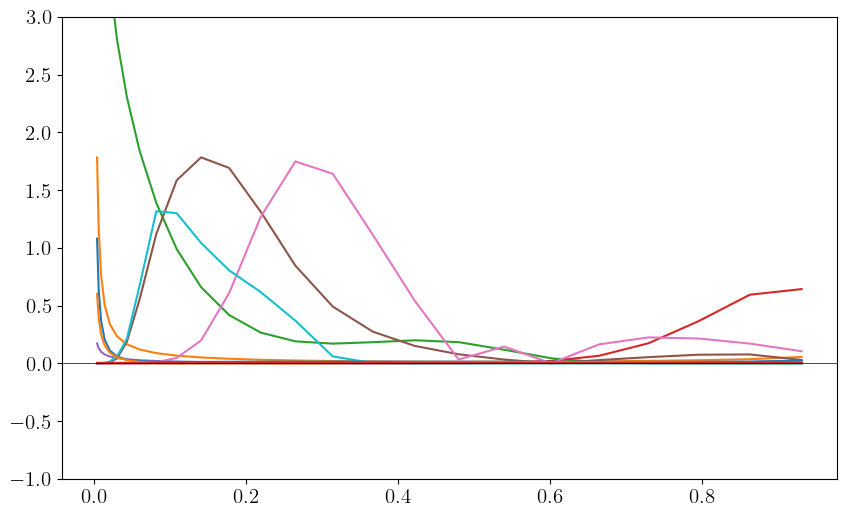

In [32]:
fig, ax = plt.subplots()
ax.set_ylim(-1,3)
for i in range(14):
    ax.plot(xgrid_torch.cpu().numpy(), pdf_m[i].detach().cpu().numpy())
ax.axhline(y=0, lw=0.5, color="k")

In [7]:
# definition of the base densities for the evolution basis
#for fullfilling the valence sum rule on s,c,b,t we set the q = q_bar

base_val_01 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_02 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_03 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_04 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_05 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_06 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_09 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_10 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))
base_val_11 = torch.distributions.Beta(torch.tensor(1.5, device=device), torch.tensor(5., device=device))

base_sea_01 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_02 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_03 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_04 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_05 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_06 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_09 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_10 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))
base_sea_11 = torch.distributions.Beta(torch.tensor(0.8, device=device), torch.tensor(5., device=device))

In [8]:
# mean_flown_uv = mean_adjust(beta_uv).mean_flown_
# mean_flown_uv = mean_adjust(beta_dv).mean_flown_
# mom_uv = torch.tensor(0.2, device=device).detach()
# mom_dv = torch.tensor(0.1, device=device).detach()

In [9]:
# Generation of L0 data
L0_data = to_sigmared(fk_array_torch, pdf_input_ev[ACTIVE_FLAVORS]).requires_grad_(False)

In [10]:
Cinv = torch.tensor(np.linalg.inv(covariance_matrix), dtype=torch.float64, device=device).requires_grad_(False)

def chi2_loss(d, t, Cinv):
    """
    TODO: ...
    """
    return (d-t).T @ (Cinv) @ (d-t)

In [22]:
hidden_dim=64
in_out_dim=1

net_01     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64)
net_02     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64)
net_03     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64)
net_04     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64)
net_05     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64) 
net_06     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64) 
net_09     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64) 
net_10     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64) 
net_11     = pdffit.nn.DFF_f(in_out_dim, hidden_dim, trafo="sig", w_init_=False).to(device).to(torch.float64) 

net_01_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
net_02_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
net_03_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
net_04_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64)
net_05_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 
net_06_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 
net_09_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 
net_10_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 
net_11_inv = pdffit.nn.DFF_g(in_out_dim, hidden_dim, trafo="sig").to(device).to(torch.float64) 

scales = torch.nn.Parameter(1/2*torch.ones((14,), device = device), requires_grad=True)

net_list = [net_01, net_02, net_03, net_04, net_05, net_06, net_09, net_10, net_11,
			net_01_inv, net_02_inv, net_03_inv, net_04_inv, net_05_inv, net_06_inv, net_09_inv, net_10_inv, net_11_inv]

In [34]:
act_pars_f, other_pars_f, act_pars_g, other_pars_g = ([], [], [], [])

for f in net_list:
	for module in f.arc:
		if isinstance(module, pdffit.CT):
			act_pars_f += list(module.parameters())
		else:
			other_pars_f += list(module.parameters())


opt = torch.optim.Adam([
	{'params': other_pars_f, 'lr': 1e-3},
	{'params': act_pars_f, 'lr': 1e-3},
	{'params': scales, 'lr': 1e-3}
]#, amsgrad=True
)

# scheduler = CyclicLR(opt, 
#                  base_lr=1e-5,     
#                  max_lr=1e-3,      
#                  step_size_up=2000,
#                  mode='triangular')

# opt_g = optim.Adam([
# 	{'params': other_pars_g, 'lr': lr_g},
# 	{'params': act_pars_g, 'lr': lr_act}
# ])

# for module in g.arc:
# 	if isinstance(module, pdffit.CT):
# 		act_pars_g += list(module.parameters())
# 	else:
# 		other_pars_g += list(module.parameters())
# opt = torch.optim.NAdam(params, lr=3e-5)

In [35]:
scale_01 = (delta_uv + delta_dv)/deltas_evo[1]

In [36]:
pdf_m

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7813e+00, 1.1570e+00, 7.5830e-01, 5.0341e-01, 3.3987e-01, 2.3422e-01,
         1.6522e-01, 1.1941e-01, 8.8327e-02, 6.6636e-02, 5.1033e-02, 3.9521e-02,
         3.0915e-02, 2.4508e-02, 1.9855e-02, 1.6658e-02, 1.4710e-02, 1.3867e-02,
         1.4049e-02, 1.5244e-02, 1.7534e-02, 2.1163e-02, 2.6735e-02, 3.5910e-02,
         5.5331e-02],
        [5.9736e+00, 5.1778e+00, 4.4842e+00, 3.8707e+00, 3.3161e+00, 2.8009e+00,
         2.3103e+00, 1.8385e+00, 1.3928e+00, 9.9291e-01, 6.6309e-01, 4.2068e-01,
         2.6788e-01, 1.9167e-01, 1.7130e-01, 1.8377e-01, 2.0028e-01, 1.8427e-01,
         1.1876e-01, 4.4209e-02, 8.1471e-03, 7.0820e-04, 3.0934e-

In [37]:
pdf_m[10]

tensor([1.0788, 0.6344, 0.3649, 0.2044, 0.1114, 0.0594, 0.0321, 0.0189, 0.0135,
        0.0121, 0.0123, 0.0132, 0.0140, 0.0145, 0.0147, 0.0147, 0.0144, 0.0141,
        0.0136, 0.0132, 0.0128, 0.0127, 0.0131, 0.0151, 0.0228],
       device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)

750   0.5435917704770121   tensor([0.0000, 1.2083, 0.9675, 0.5116, 0.0963, 0.1029, 0.3924, 0.4771, 0.4771,
        0.1886, 1.4111, 1.5496, 1.7792, 1.7792], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)


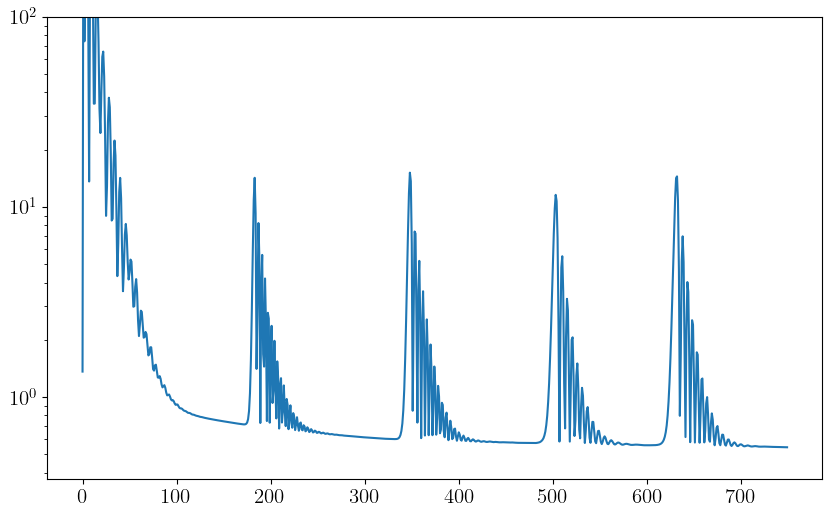

KeyboardInterrupt: 

In [38]:
loss_arr = torch.zeros(300000, device=device, dtype=torch.float64)

for itr in range(300000):
	#scales = torch.clamp(scales, min=0.0, max=1.0)
	opt.zero_grad()

	flown_01 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_01, base_val_01, base_sea_01,   scale_01)
	flown_02 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_02, base_val_02, base_sea_02, 		   0)
	flown_03 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_03, base_val_03, base_sea_03,          1)
	flown_04 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_04, base_val_04, base_sea_04,          1)
	flown_05 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_05, base_val_05, base_sea_05,          1)
	flown_06 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_06, base_val_06, base_sea_06,          1)
	flown_09 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_09, base_val_09, base_sea_09, scales[ 9])
	flown_10 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_10, base_val_10, base_sea_10, scales[10])
	flown_11 = pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_11, base_val_11, base_sea_11, scales[11])

	pdf_m = torch.zeros((14, flown_01.shape[0]), device=device, dtype=torch.float64)

	pdf_m[ 1] = deltas_evo[ 1] * flown_01
	pdf_m[ 2] = deltas_evo[ 2] * flown_02
	pdf_m[ 3] = deltas_evo[ 3] * flown_03
	pdf_m[ 4] = deltas_evo[ 4] * flown_04
	pdf_m[ 5] = deltas_evo[ 5] * flown_05
	pdf_m[ 6] = deltas_evo[ 6] * flown_06
	pdf_m[ 9] = deltas_evo[ 9] * flown_09
	pdf_m[10] = deltas_evo[10] * flown_10
	pdf_m[11] = deltas_evo[11] * flown_11

	loss = chi2_loss(to_sigmared(fk_array_torch, pdf_m[ACTIVE_FLAVORS]), L0_data, Cinv)

	loss.backward()
	opt.step()

	#averaged_model.update_parameters(model)

	if itr % 250 == 0:

		#ctr = 0

		clear_output(wait=True)
		component_diff = ((pdf_m - pdf_input_ev)**2).mean(dim=1)
		print(itr, " ", loss.item(), " ", component_diff)
		plt.plot(loss_arr[:itr].cpu().numpy())
		plt.yscale("log"); plt.ylim(None, torch.min(torch.tensor(1e2), torch.max(loss_arr)).cpu().numpy())
		plt.show()

		if itr % 10000 == 0:
			#torch.save(opt.param_groups, "/afs/ipp-garching.mpg.de/home/h/hildebra/MA/Notebooks/pythonfits/closure_fit.pt")
			pass
	loss_arr[itr] = loss.detach()

In [ ]:
scales

Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        2.1031, 0.5000, 0.5000, 0.5000, 0.5000], device='cuda:0',
       requires_grad=True)

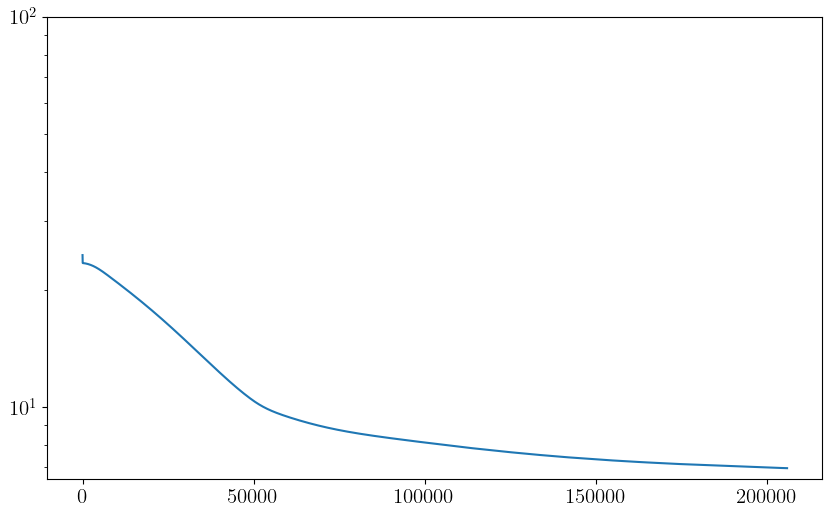

In [ ]:
plt.plot(loss_arr[:itr].cpu().numpy())
plt.yscale("log"); plt.ylim(None, 1e2)
plt.show()

In [ ]:
chi2_loss(to_sigmared(fk_array_torch, pdf_m[ACTIVE_FLAVORS]), L0_data, Cinv)

tensor(5.7746, device='cuda:0', dtype=torch.float64, grad_fn=<DotBackward0>)

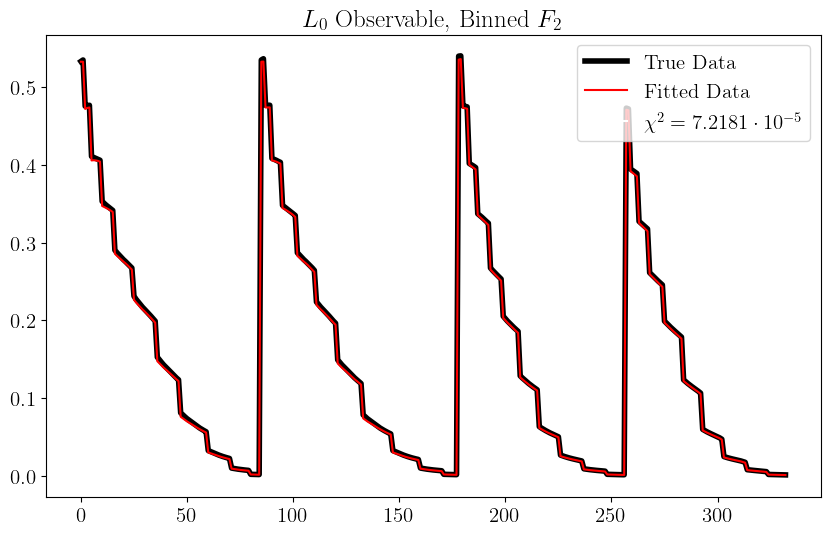

In [ ]:
fig, ax = plt.subplots()

ax.plot(L0_data.detach().cpu().numpy(), "k", label="True Data", lw=4)
ax.plot(to_sigmared(fk_array_torch, pdf_m[ACTIVE_FLAVORS]).detach().cpu().numpy(), "r", alpha=1, label="Fitted Data")

plt.title(r"$L_0$ Observable, Binned $F_2$")

ax.plot(0,0, "w", label=r"$\chi^2 = 7.2181 \cdot 10^{-5}$")

ax.legend()

#plt.savefig("observable_l0_fit.pdf", bbox_inches = "tight")

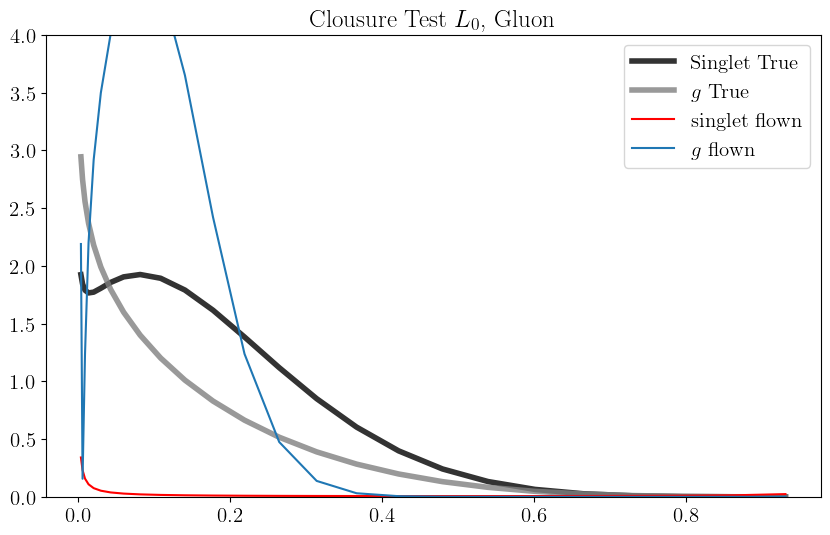

In [ ]:
fig, ax = plt.subplots()

ax.plot(xgrid_torch.cpu().numpy(), (pdf_input_ev[1]).cpu().numpy(), color ="k", lw=4, alpha=0.8, label=r"Singlet True")
ax.plot(xgrid_torch.cpu().numpy(), (pdf_input_ev[2]).cpu().numpy(), color ="grey", lw=4, alpha=0.8, label=r"$g$ True")
# ax.plot(xgrid_torch.cpu().numpy(), (pdf_input_ev[2]).cpu().numpy(), color ="grey", lw=4, alpha=0.8, label=r"Flow basis $g_0$ $\sim B(0.8, 5.0)$")
# ax.plot(xgrid_torch.cpu().numpy(), (pdf_input_ev[6]).cpu().numpy(), label="input u_b")

ax.plot(xgrid_torch.cpu().numpy(), pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_01, base_val, base_sea, scales[ 1]).detach().cpu().numpy(),
        color="red", label=r"singlet flown")
ax.plot(xgrid_torch.cpu().numpy(), pdffit.nn.flown_comb(xgrid_torch.view(-1,1), net_02, base_val, base_sea, scales[ 2]).detach().cpu().numpy(), label=r"$g$ flown")

plt.title(r"Clousure Test $L_0$, Gluon")

ax.set_ylim(0,4)

ax.legend()

#plt.savefig("gluon_l0_fit.pdf", bbox_inches = "tight")

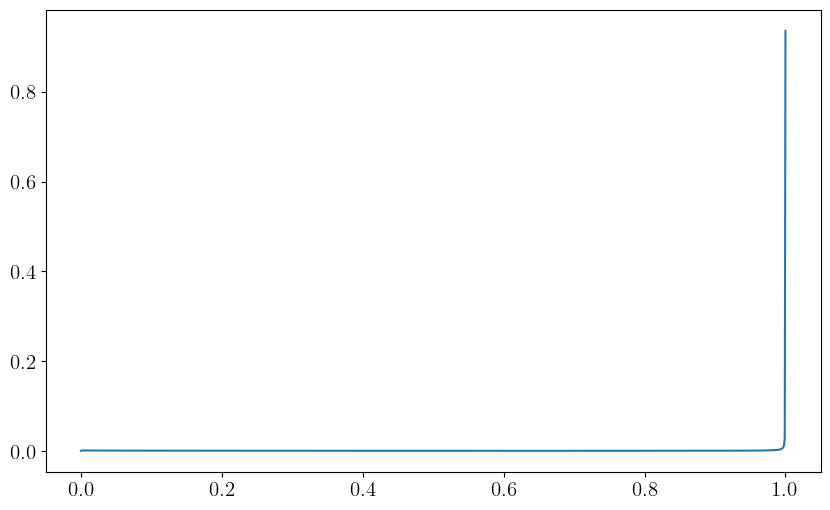

In [ ]:
plt_xrange = torch.linspace(1e-5, 1-1e-5, 1000, device=device, dtype=torch.float64)
plt.plot(plt_xrange.cpu().numpy(), db_net(plt_xrange.view(-1,1))[0].detach().cpu().numpy(), label="u_b")

(0.0, 5.5)

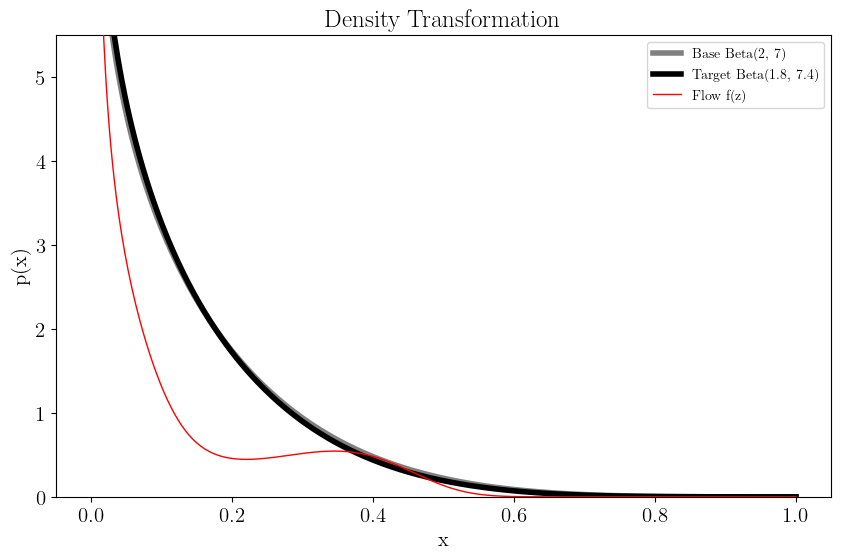

In [ ]:
pdffit.plot_densities(ub_net.to(torch.float32), ub_inv_net.to(torch.float32), beta_ub, beta_ub_in, fi_disp = (True, False))
plt.ylim(0,5.5)

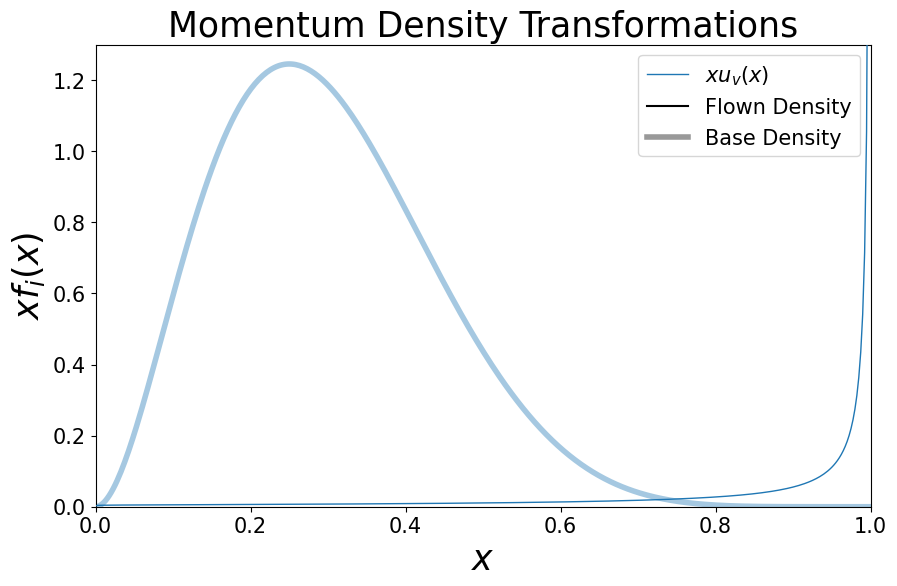

In [ ]:
plt.ylim(0, 1.3)
plt.xlim(0, 1)
bounds = (1e-4, 1-1e-4)

pdffit.plot_densities(uv_net, uv_inv_net, beta_uv, beta_uv, tb_disp=(False, True), fi_disp=(True, False), fac="momentum_u", bounds = bounds, fcolor="C0", bcolor="C0", balpha=0.4, blabel=None, flabel=r'$x u_v(x)$'         )

# pdffit.plot_densities(ub_net, ub_inv_net, beta_ub, beta_ub, tb_disp=(False, True), fi_disp=(True, False), fac=delta_usea  , bounds = bounds, fcolor="C1", bcolor="C1", balpha=0.4, blabel=None, flabel=r'$x d_v(x)$'         )
# pdffit.plot_densities(dv_net, dv_inv_net, beta_dv, beta_dv, tb_disp=(False, True), fi_disp=(True, False), fac="momentum"  , bounds = bounds, fcolor="C3", bcolor="C3", balpha=0.4, blabel=None, flabel=r'$x u_s(x)$'         )
# pdffit.plot_densities(db_net, db_inv_net, beta_db, beta_db, tb_disp=(False, True), fi_disp=(True, False), fac=delta_dsea  , bounds = bounds, fcolor="C2", bcolor="C2", balpha=0.4, blabel=None, flabel=r'$x d_s(x)$'         )
# pdffit.plot_densities(g_net , g_inv_net , beta_g , beta_g , tb_disp=(False, True), fi_disp=(True, False), fac=delta_g     , bounds = bounds, fcolor="C4", bcolor="C4", balpha=0.4, blabel=None, flabel=r'$x (g_v(x)+g_s(x))$')

plt.plot(0,0, "k", label="Flown Density")
#plt.plot(0,0, "k", ls="--", alpha=0.4, label="Mean Adjusted")
plt.plot(0,0, "k", lw=4, alpha=0.4, label="Base Density")

plt.title("Momentum Density Transformations", fontsize=25)
plt.ylabel(r"$x f_i(x)$", fontsize=25)
plt.xlabel(r"$x$", fontsize=25)
plt.legend(fontsize=15)


In [ ]:
import importlib
importlib.reload(pdffit.viz.plot_utils)
importlib.reload(pdffit.nn)
importlib.reload(pdffit)

In [ ]:
torch.tensor([delta_uv  ,2*delta_ub,delta_dv  ,2*delta_db, delta_g, 2*delta_c, 2*delta_s]).sum()

tensor(1.0000)